In [1]:
# ! pip install imbalanced-learn


In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('../내돈내산.csv')

In [38]:
data.columns

Index(['이용금액_업종기준', 'VIP등급코드', '남녀구분코드', '연령', '입회경과개월수_신용', '탈회횟수_누적',
       '최종탈회후경과월', '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내', '마케팅동의여부', '이용금액_R3M_신용체크',
       '이용금액_R3M_신용', '이용금액대', '이용건수_B0M', '이용금액_B0M', '최종이용일자', '이용후경과월',
       '이용건수_R12M', '이용금액_R12M', '최대이용금액_R12M', '이용개월수_R12M', '이용건수_R6M',
       '이용금액_R6M', '이용개월수_R6M', '이용건수_R3M', '이용금액_R3M', '이용개월수_R3M', '유효카드수',
       '이용금액_증감률', '최근_이용금액_비중'],
      dtype='object')

In [5]:
data['VIP등급코드'] = data['VIP등급코드'].replace({4:6, 5:6, 6:1, 7:2})

In [6]:
data['VIP등급코드'].value_counts()

VIP등급코드
0    2401832
2     436786
1     159860
6       1522
Name: count, dtype: int64

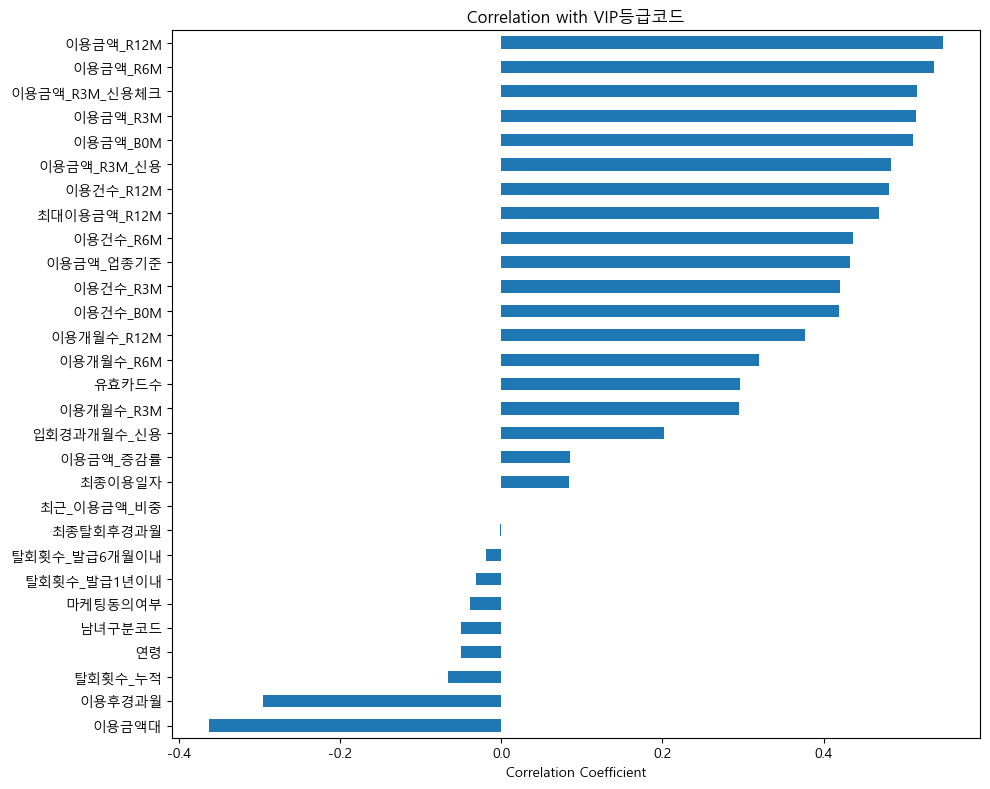

In [7]:
# 수치형 피처 중 타겟 제외
num_cols = data.select_dtypes(include='number').drop(columns=['VIP등급코드'])

# y (VIP등급코드) 와 각 피처 간의 상관계수만 추출
target_corr = data[num_cols.columns].corrwith(data['VIP등급코드']).sort_values(ascending=False)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우용 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 기호 깨짐 방지
plt.figure(figsize=(10, 8))
target_corr.plot(kind='barh')
plt.title("Correlation with VIP등급코드")
plt.xlabel("Correlation Coefficient")
plt.gca().invert_yaxis()  # 상위 상관부터 위에 오게
plt.tight_layout()
plt.show()


In [8]:
X = data.drop(columns=['VIP등급코드'])
y = data['VIP등급코드']

In [ ]:
y = y.replace({6: 3})


In [23]:
print(y.unique())

[0 2 1 3]


In [25]:
y.dtype

dtype('int64')

In [28]:
y

0          0
1          0
2          0
3          0
4          0
          ..
2999995    1
2999996    0
2999997    0
2999998    2
2999999    0
Name: VIP등급코드, Length: 3000000, dtype: int64

In [16]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# # 타겟 제외한 피처만 사용
# X = data.drop(columns=['VIP등급코드'])
# X_scaled = StandardScaler().fit_transform(X)

# # VIF 계산
# vif = pd.DataFrame()
# vif["feature"] = X.columns
# vif["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# # 출력
# print(vif.sort_values("VIF", ascending=False))


In [29]:
from sklearn.model_selection import train_test_split

# 1. 먼저 train+val vs test 분할 (예: 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. train vs val 분할 (예: val 20% of train+val → 0.2 / 0.8 = 0.25)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)


In [30]:
from xgboost import XGBClassifier
model = XGBClassifier(
     n_estimators=300,
     max_depth=4,
     learning_rate=0.05,
     objective='multi:softprob',
     use_label_encoder=False,
     eval_metric='mlogloss',
     random_state=42
 )
model.fit(X_train,y_train)

# model = XGBClassifier()

# model.fit(X_train,y_train)

c:\Users\human\anaconda3\envs\project\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:50:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [31]:
y_val_pred_proba = model.predict(X_val)
y_val_pred = model.predict(X_val)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 기본 지표 출력
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, average='macro'))  
print("Recall   :", recall_score(y_val, y_val_pred, average='macro'))
print("F1 Score :", f1_score(y_val, y_val_pred, average='macro'))

# 다중분류면 클래스별 상세 리포트
print("\n Classification Report:\n", classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



c:\Users\human\anaconda3\envs\project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\human\anaconda3\envs\project\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:56:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
 99%|===================| 2955/3000 [00:46<00:00]        

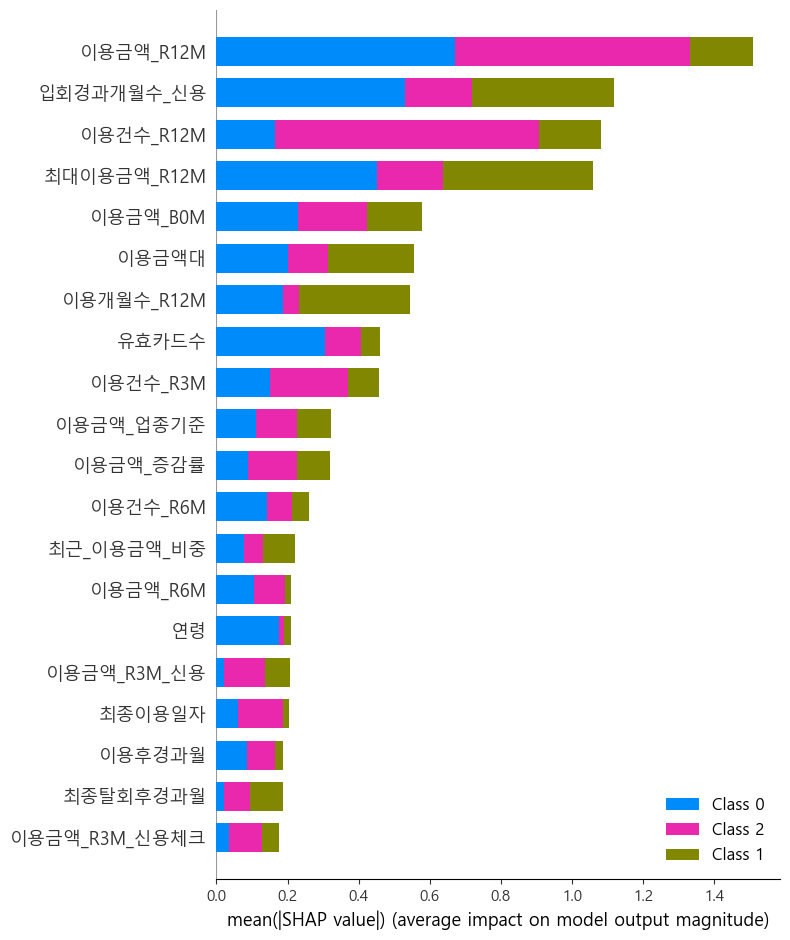

In [33]:
import shap
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우용 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 기호 깨짐 방지

X_small = X_train.sample(n=1000,random_state=42)
y_small = y_train.loc[X_small.index]

model.fit(X_small, y_small)

# 2. SHAP 설명자 생성
explainer = shap.Explainer(model, X_small)  # ← 여기 중요! TreeExplainer(X_train) 말고!

# 3. SHAP 값 계산
shap_values = explainer(X_small, check_additivity=False)  # 이건 shap.Explanation 객체로 나옴

# 4. summary plot 그리기 (자동으로 여러 클래스 처리됨)
shap.summary_plot(shap_values, X_small, plot_type='bar')


과적합

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compare_train_val_performance(y_train, y_train_pred, y_val, y_val_pred):
    print("=== Train vs Validation Performance ===")
    print(f"{'Metric':<12} | {'Train':>8} | {'Validation':>10}")
    print("-" * 38)
    print(f"{'Accuracy':<12} | {accuracy_score(y_train, y_train_pred):8.4f} | {accuracy_score(y_val, y_val_pred):10.4f}")
    print(f"{'Precision':<12} | {precision_score(y_train, y_train_pred, average='macro'):8.4f} | {precision_score(y_val, y_val_pred, average='macro'):10.4f}")
    print(f"{'Recall':<12} | {recall_score(y_train, y_train_pred, average='macro'):8.4f} | {recall_score(y_val, y_val_pred, average='macro'):10.4f}")
    print(f"{'F1 Score':<12} | {f1_score(y_train, y_train_pred, average='macro'):8.4f} | {f1_score(y_val, y_val_pred, average='macro'):10.4f}")


In [35]:
y_train_pred = model.predict(X_train)


compare_train_val_performance(y_train, y_train_pred, y_val, y_val_pred)


=== Train vs Validation Performance ===
Metric       |    Train | Validation
--------------------------------------
Accuracy     |   0.8593 |     0.8840


c:\Users\human\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision    |   0.5245 |     0.6884
Recall       |   0.4577 |     0.5199
F1 Score     |   0.4826 |     0.5540


In [36]:
import joblib
joblib.dump(model, 'final_vip_model.pkl')

['final_vip_model.pkl']